# Gaussian Mixture Model

__Gaussian Mixture Model__ es un modelo probabilístico en el que se considera que las obseervaciones siguen una distribución probabilística formada por la combinacion de multiples distribuciones normales (componentes). Puede entenderse como una generalizacion de K-Means con la que, en lugar de asignar cada observacion a un unico _cluster_, se obtiene una distribucion de probabilidad de pertenencia a cada uno.

Ajustar un modelo GMM consiste en estimar los parametros que definen la funcion de distribucion de cada componente: la media y la matriz de covarianza. Por ejemplo, si el modelo tiene dos componentes, hay que encontrar la media y la matriz de covarianzas de cada una. Si es un problema multidimensional, por ejemplo de tres variables, la media de cada componente es un vector de 3 valores y la matriz de covariana una matriz de 3x3. El algoritmo mas empleado para realizar el ajuste es _Expectation Maximization (EM)_.

Una vez aprendido los parametros, se puede calcular la densidad de probabilidad que tiene cada observacion de pertenecer a cada componente y al conjunto de la distribucion. Observaciones con muy poca densidad de probabilidad pueden considerarse como anomalias.

__Densidad de probabilidad__


Al tratarse de un modelo probabilistico, el ajuste de un modelo GMM genera en realidad una funcion de densidad de probabilidad. El concepto de densidad de probabilidad puede entenderde como un analogo al de probabilidad en distribuciones discretas, pero, en lugar de acotada en el rango [0, 1], puede tomar valores [0, +inf]. El valor de densidad de probabilidad es una medida relativa de verosimilitud (_likelihood_), cuanto mayor es el valor de densidad de una observacion, mayor evidencia de que la observacion pertenece a una determinada distribucion.

Con frecuencia, para facilitar los calculos, en lugar de utilizar el valor de densidad se utiliza su logaritmo. La interpretacion es la misma, cuanto mayor su valor, mayor la evidencia de que la observacion pertenece a la distribucion.



In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

## Lectura de datos

In [5]:
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/' \
      + 'Estadistica-machine-learning-python/master/data/geyser.csv'
datos_X = pd.read_csv(url)
datos_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   waiting   299 non-null    int64  
 1   duration  299 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 4.8 KB


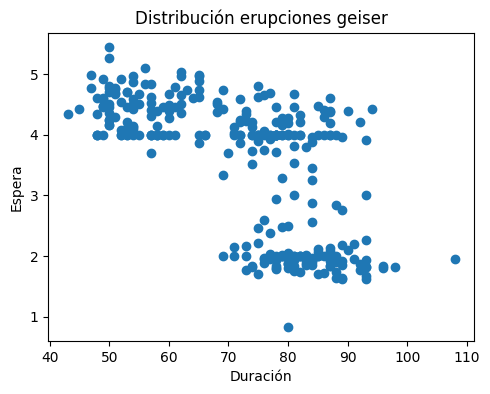

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.5, 4))
ax.scatter(datos_X.waiting, datos_X.duration)
ax.set_title('Distribución erupciones geiser')
ax.set_ylabel('Espera')
ax.set_xlabel('Duración');

## Modelo

__Como saber el numero de componentes y el tipo de matriz de covarianza?__

Al tratarse de un problema no supervisado, no hay forma de conocer de antemano el numero de componentes y tipo de matriz de covarianza optimos. Afortunadamente, al ser un modelo probabilistico, se puede recurrir a metrica como el _Akaike information criterion (AIC)_ o _Bayesian information criterion (BIC)_ para identificar como de bien se ajustan los datos observados al modelo creado, a la vez que se controla con el exceso de _obverfitting_.

> En la implementacion de _Scikit-Learn_, para ambas metricas, cuanto mas bajor el valor, mejor.

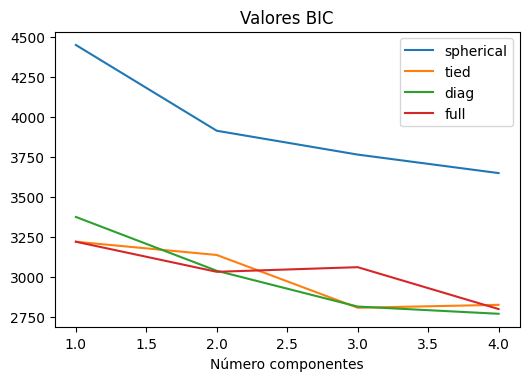

In [7]:
fig, ax = plt.subplots(figsize=(6, 3.84))

n_components = range(1, 5)
covariance_types = ['spherical', 'tied', 'diag', 'full']

for covariance_type in covariance_types:
    valores_bic = []
    
    for i in n_components:
        modelo = GaussianMixture(n_components=i, covariance_type=covariance_type)
        modelo = modelo.fit(datos_X)
        valores_bic.append(modelo.bic(datos_X))
        
    ax.plot(n_components, valores_bic, label=covariance_type)
        
ax.set_title("Valores BIC")
ax.set_xlabel("Número componentes")
ax.legend();

Viendo la metrica BIC, su valor se estabiliza a partir de las 3 componentes, lo que coincide con la idea obtenida en la inspeccion visual de los datos.

In [8]:
modelo_gmm = GaussianMixture(
                n_components    = 3,
                covariance_type = 'diag',
                random_state    = 123, 
             )

modelo_gmm.fit(X=datos_X)

GaussianMixture(covariance_type='diag', n_components=3, random_state=123)

## Prediccion de probabilidades

In [9]:
log_probabilidad_predicha = modelo_gmm.score_samples(X=datos_X)

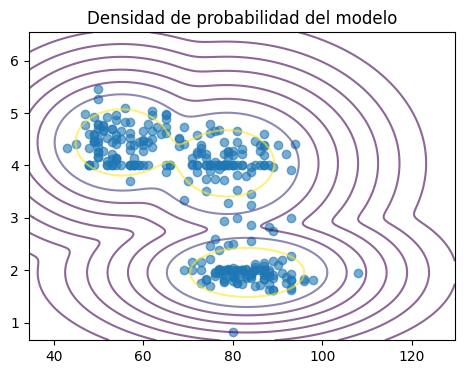

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.5, 4))

# Grid de valores dentro del rango observado
x = np.linspace(min(datos_X.waiting)*0.8, max(datos_X.waiting)*1.2, 1000)
y = np.linspace(min(datos_X.duration)*0.8, max(datos_X.duration)*1.2, 1000)
xx, yy = np.meshgrid(x, y)

# Densidad de probabilidad de cada valor del grid
scores = modelo_gmm.score_samples(np.c_[xx.ravel(), yy.ravel()])
scores = np.exp(scores) # Los valores están en log

ax.scatter(datos_X.waiting, datos_X.duration, alpha=0.6)
ax.contour(
    xx, yy, scores.reshape(xx.shape), alpha=0.6,
    levels=np.percentile(scores, np.linspace(0, 100, 10))[1:-1]
)
ax.set_title('Densidad de probabilidad del modelo');

## Deteccion de anomalias

In [11]:
df_resultados = datos_X.copy()
df_resultados['log_proba'] = log_probabilidad_predicha
df_resultados = df_resultados.sort_values(by='log_proba')
top_5_anomalias = df_resultados.head(10)
top_5_anomalias

,waiting,duration,log_proba
148,80,0.833333,-14.168780
60,108,1.950000,-10.363347
242,93,3.000000,-10.010828
26,88,2.833333,-9.262396
269,89,2.750000,-8.861988
169,84,2.866667,-8.661795
11,50,5.450000,-8.160330
109,78,2.933333,-8.001557
83,81,3.000000,-7.592703
34,76,2.600000,-7.392119


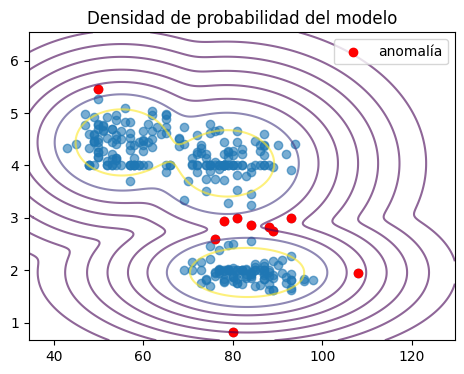

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.5, 4))

# Grid de valores dentro del rango observado
x = np.linspace(min(datos_X.waiting)*0.8, max(datos_X.waiting)*1.2, 1000)
y = np.linspace(min(datos_X.duration)*0.8, max(datos_X.duration)*1.2, 1000)
xx, yy = np.meshgrid(x, y)

# Densidad de probabilidad de cada valor del grid
scores = modelo_gmm.score_samples(np.c_[xx.ravel(), yy.ravel()])
scores = np.exp(scores) # Los valores están en log

ax.scatter(datos_X.waiting, datos_X.duration, alpha=0.6)
ax.scatter(top_5_anomalias.waiting, top_5_anomalias.duration, c="red", label='anomalía')
ax.contour(
    xx, yy, scores.reshape(xx.shape),
    alpha=0.6, cmap='viridis',
    levels=np.percentile(scores, np.linspace(0, 100, 10))[1:-1]
)
ax.set_title('Densidad de probabilidad del modelo');
ax.legend();